In [3]:
%matplotlib inline
!pip install gym
!pip install box2d-py
!pip install pyvirtualdisplay

!sudo apt-get install xvfb

    100% |████████████████████████████████| 450kB 10.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/d1/8c/16/1c64227974ae29c687e4cc30fd691d5c0fd40f54446dde99da
  Stored in directory: /root/.cache/pip/wheels/41/22/19/af15ef6264c58b625a82641ed7483ad05e258fbd8925505227
Successfully built pyvirtualdisplay EasyProcess
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.2 [783 kB]
Fetched 783 kB in 2s (340 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like prog

In [0]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from pyvirtualdisplay import Display

gym.logger.set_level(40)

env = gym.make('LunarLander-v2').unwrapped
env.seed(0)
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

display = Display(visible=0, size=(1400, 900))
display.start()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
class ReplayMemory:

    def __init__(self, buffer_size, batch_size, seed):

        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "next_state", "reward", "done"])
        self.seed = random.seed(seed)
    
    def push(self, state, action, next_state, reward, done):

        e = self.experience(state, action, next_state, reward, done)
        self.memory.append(e)
    
    def sample(self):

        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
                                  
        return (states, actions, next_states, rewards, dones)

    def __len__(self):

        return len(self.memory)

In [0]:
class DQN(nn.Module):

    def __init__(self, h, w):
      
        super(DQN, self).__init__()  
        self.layer1   = nn.Sequential(nn.Conv2d(3, 16, 5, stride=2),\
                                      nn.BatchNorm2d(16),\
                                      nn.ReLU())
        
        self.layer2   = nn.Sequential(nn.Conv2d(16, 32, 5, stride=2),\
                                      nn.BatchNorm2d(32),
                                      nn.ReLU())
        
        self.layer3   = nn.Sequential(nn.Conv2d(32, 32, 5, stride=2),\
                                      nn.BatchNorm2d(32),\
                                      nn.ReLU(),\
                                      nn.MaxPool2d(kernel_size=2))
        
        self.layer4   = nn.Sequential(nn.Dropout() ,\
                                      nn.Linear(3585, 1024),\
                                      nn.ReLU()) 
        
        self.layer5   = nn.Sequential(nn.Linear(1024, 4),\
                                      nn.Softmax())
        
        self.layer_a  = nn.Sequential(nn.Linear(4, 1),\
                                      nn.ReLU()) 
        
    def forward(self, x, a):
#         print(x, a)
        
        out = self.layer1(x.to(device))
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        
        a   = self.layer_a(torch.FloatTensor(np.array(a)/4).to(device))
        if(a.shape[0]==BATCH_SIZE):
            out = torch.cat((out, a), 1)
        else:
            out = torch.cat((out[0], a), 0)
            
        out = self.layer4(out)
        out = self.layer5(out)
        
        return out

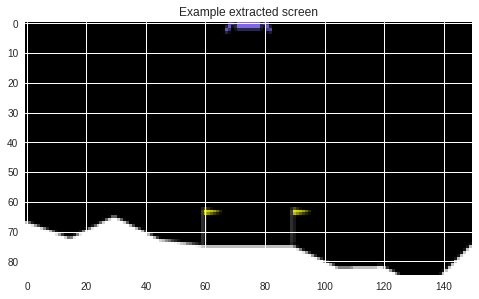

In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(100, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    
    
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    new_screen = resize(screen)
    
    fin_screen = new_screen[:, :85]

    return fin_screen.unsqueeze(0).to(device)


env.reset()
screen = get_screen()
plt.figure()
plt.imshow(screen.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [0]:
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 500
TARGET_UPDATE = 1
SEED = 0
MEMORY_SIZE = int(10e5)
TAU = 0.05
POLYAK = 1 - TAU
LR = .0016

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
state = torch.cat([init_screen, init_screen, init_screen], 2)
_, _, screen_height, screen_width = init_screen.shape
policy_net = DQN(screen_height, screen_width).to(device)
target_net = DQN(screen_height, screen_width).to(device)

try:
  policy_net.load_state_dict(torch.load("./policy.nn", map_location=device))
except:
  print("There isnt old weights")
  
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), LR)
memory = ReplayMemory(MEMORY_SIZE, BATCH_SIZE, SEED)

def select_action(state, i, actions):
    sample = random.random()
    
    if(i<10):
        return torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long)
      
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                    math.exp(-1. * i / EPS_DECAY)
    if sample > eps_threshold :
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state, actions).max(0)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long)
      
def good_action(state, actions):
    with torch.no_grad():
        # t.max(1) will return largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        return policy_net(state, actions).max(0)[1].view(1, 1)
      
def test():
    test_rewards = []
    for i in range(100):
        env.reset()
        current_screen = get_screen()
    
        state = current_screen - current_screen
    
        done = False
        reward = 0
        rew_per_episode = 0
        for j in count():
          
            action = good_action(state)
            _, reward, done, _ = env.step(action.item())
        
            rew_per_episode += reward

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen()

            if not done:
                next_state = last_screen - current_screen
            else:
                next_state = state
            memory.push(state, action, next_state, reward, done)

            # Move to the next state
            state = next_state
            # Perform one step of the optimization (on the target network)
            if done:
                break
        test_rewards.append(rew_per_episode)       
    return np.mean(test_rewards)

In [0]:
def optimize_model():
    
    experiences = memory.sample()
    states, actions4, next_states, rewards, dones = experiences
    
    actions = actions4.reshape(4, 64)[0]

    Q_argmax = target_net(torch.FloatTensor(next_states).to(device), actions4).detach()
    _, a_prime = Q_argmax.max(1)
  
    Q_targets_next = target_net(torch.FloatTensor(next_states).to(device), actions4).detach().gather(1, a_prime.unsqueeze(1))
    
    Q_targets = torch.FloatTensor(rewards).to(device) + (GAMMA * Q_targets_next * (1 - torch.FloatTensor(dones).to(device)))
  
    Q_expected = policy_net( torch.FloatTensor(states).to(device), actions4)
    
    loss = F.mse_loss(Q_targets, Q_expected.gather(1, torch.LongTensor(actions.reshape(64,1)).to(device)))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [0]:
num_episodes = 100
passed = 0
plt.figure()
reward_sum = 0
rew_max = -999999
lr=LR
tracked_rewards = []
for i_episode in count():
    # Initialize the environment and state
    env.reset()
    screen1 = get_screen()
    screen2 = screen1
    screen3 = screen2
    actions = [0 ,0, 0, 0]
    state = torch.cat([screen1, screen2, screen3], 2).cpu()
    
    done = False
    reward = 0
    rew_per_episode = 0
    for t in count():
        # Select and perform an action
        action = select_action(state, i_episode, actions)
        _, reward, done, _ = env.step(action.item())
        
        rew_per_episode += reward

        # Observe new state
        screen4 = get_screen()
        
        if not done:
            next_state = torch.cat([screen2, screen3, screen4], 2).cpu()
        else:
            next_state = state
        
        actions = [actions[1],\
                   actions[2],\
                   actions[3],\
                   action.item()]
        
        memory.push(state.cpu(), actions, next_state, reward, done)
        
        # Move to the next state
        state = next_state
        screen1 = screen2
        screen2 = screen3
        screen3 = screen4
        # Perform one step of the optimization (on the target network)
        if(BATCH_SIZE<=len(memory)):
            optimize_model()
        if done:
            tracked_rewards.append(rew_per_episode)
            break
            
    # Update the target network, copying all weights and biases in DQN
        if(t%4==0):
            for param, target_param in zip(policy_net.parameters(), target_net.parameters()):
                target_param.data.copy_( (POLYAK * target_param.data) + ((1 - POLYAK) * param.data))
    
    print('\rEpisode {} \tLearning rate {:.6f} \tAverage Score: {:.2f}'.format(i_episode+1, lr, np.mean(tracked_rewards)), end="")
    
    if((i_episode+1)%100==0):
      
        print('\rEpisode {} \tLearning rate {:.6f} \tAverage Score: {:.2f}'.format(i_episode+1, lr, np.mean(tracked_rewards)))

        torch.save(policy_net.state_dict(), "policy.nn")
        
        lr=LR/(i_episode+1)*100
        optimizer = optim.Adam(policy_net.parameters(), lr=lr)

        if(np.mean(tracked_rewards)>=195):
            test_count = 0
            for seed in [135, 6589, 5]:
                env.seed(seed)
                test_mark = test()
                print(test_mark)
                if(test_mark>=195):
                    test_count+=1
                if(test_count>2):
                    break
        tracked_rewards = []
env.close()
plt.figure
plt.show() 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode 100 	Learning rate 0.001600 	Average Score: -165.61
Episode 200 	Learning rate 0.001600 	Average Score: -155.34
Episode 252 	Learning rate 0.000800 	Average Score: -165.31

In [0]:
print(np.mean(tracked_rewards))

NameError: ignored

In [0]:
def good_action(state):
    with torch.no_grad():
        # t.max(1) will return largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        return policy_net(state).max(1)[1].view(1, 1)
      
def test():
    test_rewards = []
    for i in range(100):
        env.reset()
        current_screen = get_screen()
    
        state = current_screen - current_screen
    
        done = False
        reward = 0
        rew_per_episode = 0
        for j in count():
          
            action = good_action(state)
            _, reward, done, _ = env.step(action.item())
        
            rew_per_episode += reward

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen()

            if not done:
                next_state = last_screen - current_screen
            else:
                next_state = state
    
            memory.push(state, action, next_state, reward, done)

            # Move to the next state
            state = next_state
            # Perform one step of the optimization (on the target network)
            if done:
                break
        test_rewards.append(rew_per_episode)       
    return np.mean(test_rewards)

In [0]:
test()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


-434.45062135944676

In [0]:
device

device(type='cuda')